In [1]:
import numpy as np 
import pickle
from pathlib import Path
import matplotlib.pyplot as plt


## 0. Preparation 
First, run ``run_models.sh`` to obtain the necessary data for the figure. This script trains all prob. learners and saves the results to the folder ``./results``

## 1. Load predictive means, variances, RMSE and prediction interval coverage rates

In [3]:
methods = ['lli_vi_closed_full_cov', 'lli_gibbs_ridge',  'mc_dropout', 'bnn']
method_names = ['LLI + VI\nclosed\n full cov', 'LLI + Ridge + Gibbs', 'MC dropout', 'BNN']
#  'lli_vi_ridge', 'lli_vi_horseshoe', 'lli_gibbs_ridge',  , lli_vi_fac_ridge, lli_vi_fac_horseshoe
dict_list = []
for method in methods:
    out_dict_path = Path(f"./results/out_dict_{method}.pkl")

    with open(out_dict_path, "rb") as f:
        loaded_dict = pickle.load(f)
    dict_list.append(loaded_dict.copy())

In [4]:
linestyles =  ['dashed', '-','dashdot', (0, (1, 1)) ] # , (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5))

Text(0.15, 0.6, 'Overconfident')

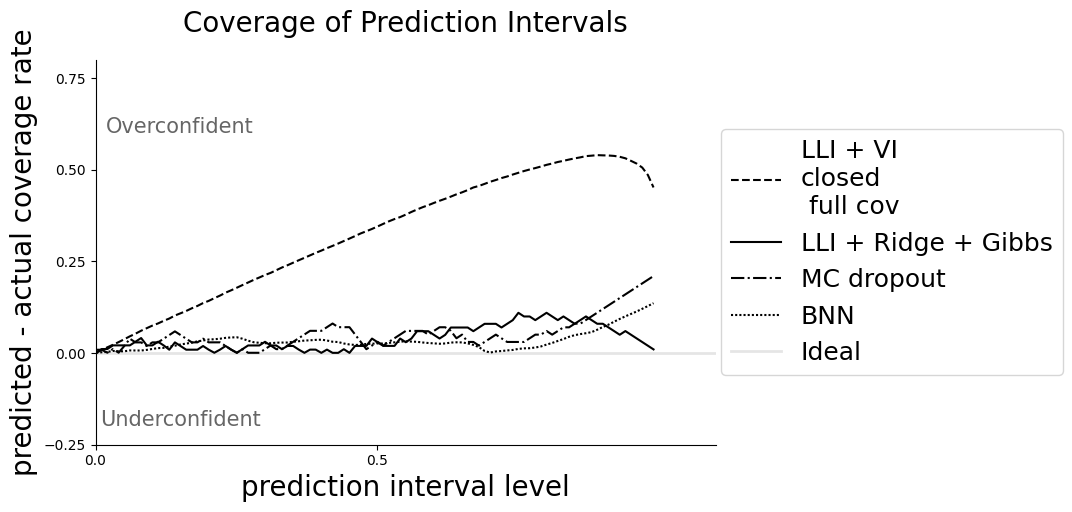

In [5]:

levels = np.linspace(0.001, 0.99, 100)
fig, axs = plt.subplots(1,1, figsize = (8,5))
for method, dict, name, linestyle in zip(methods, dict_list, method_names, linestyles):
    axs.plot(levels,  np.abs(levels - dict['coverage']), 
                    color = 'black', label = name, linestyle = linestyle
                    )
axs.legend()
axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)
axs.legend(loc = 'center right', ncols = 1, fontsize = 18, bbox_to_anchor=(1.58, 0.5)) #
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, .8)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('predicted - actual coverage rate', fontsize = 20)
x_text = 0.15
axs.text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs.text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)

In [ ]:
fig, axs = plt.subplots(1,1, figsize = (8,5))
for i, (coverage, label, linestyle ) in enumerate(zip([coverage_lli, coverage_lli_vi_no_temp, coverage_lli_vi_temp, coverage_gibbs_ridge, coverage_bnn, coverage_mc_dropout], 
                                           ['Closed', 'VI Gauss; closed', 'VI Gauss; closed, temp', 'Gibbs + ridge', 'BNN', 'MCD'],
                                           ['dashed', '-', 'dashdot', (0, (1, 1)), (0, (3, 5, 1, 5, 1, 5)) ])):
    axs.plot(levels,  np.abs(levels - coverage), 
             linestyle = linestyle, 
             label = label, color = 'black'
             )

axs.axhline(y=0, color='black', linestyle='-', 
            linewidth=2, label='Ideal', alpha = .1)

axs.legend(loc = 'center right', ncols = 1, fontsize = 18, bbox_to_anchor=(1.58, 0.5)) #
axs.set_xticks(np.arange(-1, 1, .5))
axs.set_yticks(np.arange(-0.25, 1.5, .25))
axs.set_xlim(-0, 1.1)
axs.set_ylim(-.25, .8)
axs.set_title(f'Coverage of Prediction Intervals', pad = 20, size = 20)
axs.grid(False)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_xlabel('prediction interval level', fontsize = 20)
axs.set_ylabel('predicted - actual coverage rate', fontsize = 20)
x_text = 0.15
axs.text(x_text, -0.2, 'Underconfident', fontsize=15, color='black', ha='center', alpha = 0.6)
axs.text(x_text, 0.6, 'Overconfident', fontsize=15, color='black', ha='center', alpha = 0.6)

fig.savefig('figures/coverage.pdf', bbox_inches = 'tight')